<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/german_to_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 16th August, 2019
# Myfolder: /home/ashok/Documents/germanToenglish
# VM: lubuntu_deeplearning_II.vdi

## Import Required Libraries

In [1]:
# https://medium.com/analytics-vidhya/a-must-read-nlp-tutorial-on-neural-machine-translation-the-technique-powering-google-translate-c5c8d97d7587
# Use of Sparse Categorical Cross-entropy:
#     https://www.dlology.com/blog/how-to-use-keras-sparse_categorical_crossentropy/?t=156531526256#rating-57  
# Tab-delimited Bilingual Sentence Pairs 
#  Hindi--English:   http://www.manythings.org/anki/

## Call libraries
# 1.0 For data manipulation
import numpy as np
import pandas as pd

# 1.1 For text cleaning
import string
import re

# 1.2 For NN model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# 1.3 For text processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1.4 For loading model
from tensorflow.keras.models import load_model

# 1.5 Misc & for plotting model
import os, time
import matplotlib.pyplot as plt

# 2.0 Set some options
# 2.1 Display graphs inline
%matplotlib inline
# 2.2 Display full pandas column
pd.set_option('display.max_colwidth', 200)

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


__Download__ first the text file that contains English sentences and coresponding German sentence separated by tab (ie pairs of sentences. One pair per line) from [here](http://www.manythings.org/anki/deu-eng.zip). and extract this file "deu.txt" in your working directory.

## Define functions to read data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [3]:
# 3.0 Define function to read raw text file
#     and return full file as ONE string
def read_text(filename):
    # 3.1 Open the file, read only ('r') and text ('t') modes
    file = open(filename, mode='rt', encoding='utf-8')
    # 3.2 Read all text as one string
    #     newlines are substituted by \n 
    #     and tabs by \t
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs. Each pair is a list. So we have a list of lists. <br> Each pair is separated by '\n'. So we first split on '\n'. And then split each pair into English sentences and German sentences by splitting on '\t'.

In [4]:
# 4. 
#    i) Split a string into multiple strings 
#       at newline, we get list of strings.
#    ii) Then, split each string on tab and put 
#        both parts of split in a list.
#
#    Example text = 'Hi.\tHallo!\nHi.\tGrüß Gott!\nRun!\tLauf!\n'
def to_lines(text):
    # 4.1 Ist remove leading and trailing spaces strip()
    #     then split it at newline
    #     'Hi.\tHallo!\nHi.\tGrüß Gott!\nRun!\tLauf!\n' transforms to
    #     ['Hi.\tHallo!', 'Hi.\tGrüß Gott!','Run!\tLauf!']
    sentences = text.strip().split('\n')
    # 4.2 Next split over tab to create two words. 
    #     This splitting creates an inner list
    #     [['Hi.', 'Hallo!'], ['Hi.','Grüß Gott!]',['Run!','Lauf!']]
    sentences = [i.split('\t') for i in sentences]
    return sentences 

## Mount gdrive

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
# Path to data folder:
pathToFolder = "/gdrive/MyDrive/Colab_data_files/germantoenglish"

#### Read Data<br>
Let us now read and look at the sentences

In [8]:
# 5.0 Where is our file 'deu.txt'
os.chdir(pathToFolder)
# 5.1 Read it as a string
#     It contains, line by line:
#     english    german  pairs

data = read_text("deu.txt")

In [9]:
# 5.2 Check
print(type(data))        # Data is one very long string
print(len(data))         # 12724556 characters
print(data[:50])         # First 50 characters

<class 'str'>
12724556
Hi.	Hallo!
Hi.	Grüß Gott!
Run!	Lauf!
Wow!	Potzdonn


In [10]:
# 6. Transform read file to a list of lists.
#    Each inner list has [english  german] pair
deu_eng = to_lines(data)


In [13]:
# 6.1 Check
print(type(deu_eng))     # List
print(len(deu_eng))      # Elements in the list: 176692


<class 'list'>
176692
[['Hi.', 'Hallo!'], ['Hi.', 'Grüß Gott!'], ['Run!', 'Lauf!'], ['Wow!', 'Potzdonner!'], ['Wow!', 'Donnerwetter!']]
[['Tom lied.', 'Tom log.'], ['Tom lies.', 'Tom lügt.'], ['Tom lost.', 'Tom hat verloren.'], ['Tom paid.', 'Tom hat gezahlt.'], ['Tom quit.', 'Tom hat aufgehört.'], ['Tom swam.', 'Tom schwamm.'], ['Tom swam.', 'Tom ist geschwommen.'], ['Tom wept.', 'Tom weinte.'], ["Tom's up.", 'Tom ist auf.'], ['Too late.', 'Zu spät.']]


In [ ]:
print(deu_eng[:5])       # List of 5 elements or pairs
print(deu_eng[400:410])  # List of lists

In [18]:
# 6.2 Convert the list to a numpy array 
#      We now have an array with feature 
#      [0] for english and feature [1] for german

deu_eng = np.array(deu_eng)
print(deu_eng.shape)     # (176692, 2)
print(deu_eng[500,:])

(176692, 2)
['Go for it.' 'Tue es.']


In [21]:
# 6.2.1
deu_eng[410:415]
print("\n---")
print(deu_eng[410:415, 0])     # List of english sentences
print("\n---")
print(deu_eng[410:415, 1])     # Corresponding list of german sentences

array([['Trust me.', 'Vertraue mir.'],
       ['Trust me.', 'Vertraut mir!'],
       ['Trust me.', 'Vertrauen Sie mir!'],
       ['Try hard.', 'Versuch es richtig!'],
       ['Use this.', 'Nimm das hier!']], dtype='<U380')


---
['Trust me.' 'Trust me.' 'Trust me.' 'Try hard.' 'Use this.']

---
['Vertraue mir.' 'Vertraut mir!' 'Vertrauen Sie mir!'
 'Versuch es richtig!' 'Nimm das hier!']


The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [22]:
# 6.3
deu_eng = deu_eng[:50000,:]     # Our RAM and time is limited. Take less pairs

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [23]:
# 6.4
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Mary has very long hair.', 'Maria hat sehr langes Haar.'],
       ["Mary is Tom's secretary.", 'Maria ist Toms Sekretärin.'],
       ['Mary is a married woman.', 'Maria ist eine verheiratete Frau.']],
      dtype='<U380')

#### Remove punctuation

We will get rid of the punctuation marks, and then convert the text to lower case.

In [24]:
# 7.0 Remove punctuation
# Ref: https://www.geeksforgeeks.org/python-maketrans-translate-functions/
"""
    Syntax : maketrans(str1, str2, str3)

    Parameters :
    str1 : Specifies the list of characters that need to be replaced.
    str2 : Specifies the list of characters with which the characters need to be replaced.
    str3 : Specifies the list of characters that needs to be deleted.

    Returns : Returns the translation table which specifies the conversions that can be used by translate()
              It returns a dictionary mapping Unicode integers to Unicode ordinals, strings or None.

"""


'\n    Syntax : maketrans(str1, str2, str3)\n\n    Parameters :\n    str1 : Specifies the list of characters that need to be replaced.\n    str2 : Specifies the list of characters with which the characters need to be replaced.\n    str3 : Specifies the list of characters that needs to be deleted.\n\n    Returns : Returns the translation table which specifies the conversions that can be used by translate()\n              It returns a dictionary mapping Unicode integers to Unicode ordinals, strings or None.\n\n'

In [25]:
s = "this is a good book!"
str.maketrans('ig', 'wj', "o")

{103: 106, 105: 119, 111: None}

In [26]:
s.translate({103: 106, 105: 119, 111:None})

'thws ws a jd bk!'

In [27]:
print(string.punctuation)
s = "this , is ; a good book!"
s.translate(str.maketrans('', '', string.punctuation))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


'this  is  a good book'

In [ ]:
# 7.1  string.punctuation is python constant
#conv_table = str.maketrans('', '', string.punctuation)    # Outputs  a dictinoary
#conv_table    # Maps all unicode punctuation characters to None

In [28]:
# 7.2 Clear English column

#     From every element (string) of 1D array deu_eng[:,0], remove punctuation and collect
#      all elements (strings) back into a list. Convert that list to 1D array

deu_eng[:,0] = np.array([s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]])

In [29]:
# 7.3 Similarly for German column:

deu_eng[:,1] = np.array([s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]])

# 7.4
deu_eng[:4, :]

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ['Wow', 'Potzdonner']], dtype='<U380')

#### Lowercase conversion

In [30]:
# 7.5 Convert both to lowercase:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

In [31]:
# 7.6
print(deu_eng[:4, 0])     # Column with index 0, 1D array of English sentences
print(deu_eng[:4, 1])     # Column with index 1, 1D array of German sentences

['hi' 'hi' 'run' 'wow']
['hallo' 'grüß gott' 'lauf' 'potzdonner']


#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

##### What is our sentence length?

In [ ]:
# 8.0 Empty lists to store sequence length in each column
eng_l = []       # For english sentences
deu_l = []       # For german sentences

# 8.1 Populate the lists with sentence lengths
#     English column
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))
    
# 8.2 German column
for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
# 8.3 Create a dataframe of these length
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.head()

,eng,deu
0,1,1
1,1,2
2,1,1
3,1,1
4,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa92463f450>,
      dtype=object)

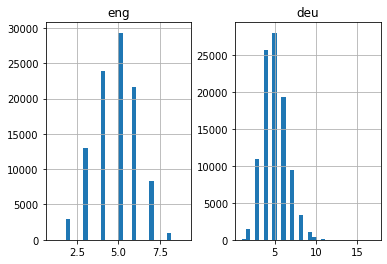

In [ ]:
# 8.4 Let us look at the overall distribution of lengths
#     in the two languages. We can then decide cut-off length
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8. We will keep both as 8.

##### Vectorize now

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

By default, all punctuation is removed, turning the texts into space-separated sequences of words (words maybe include the ' character). These sequences are then split into lists of tokens. They will then be indexed or vectorized. 

0 is a reserved index that won't be assigned to any word.

In [ ]:
"""
Ref: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
Tokenizer(
          num_words=None,                                     # the maximum number of words to
                                                              #   keep, based on word frequency. 
                                                              #     Only the most common num_words-1 
                                                              #       words will be kept. 
          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',     # a string where each element is a char 
                                                              #  that will be filtered from the texts.
                                                              #    The default is all punctuation, plus
                                                              #      tabs and line breaks, minus the ' char
          lower=True,                                         # Convert text to lowercase
          split=' ',                                          # Separator for word splitting
          char_level=False,                                   # If True, every char will be treated as token
          oov_token=None,                                     # if given, it will be added to word_index and 
                                                              #   used to replace out-of-vocabulary words 
                                                              #     during text_to_sequence calls 
          document_count=0
          )

"""

In [32]:
# 6.3 Train tokenizer
#     https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
#     Tokenizer filters punctuation, tabs and line-breaks
#
%%time

tok_eng = Tokenizer()                # Create Tokenizer() object
tok_eng.fit_on_texts(deu_eng[:, 1])  # Just training. No transformation as yet


CPU times: user 649 ms, sys: 0 ns, total: 649 ms
Wall time: 653 ms


In [33]:
# 6.3.1

%%time

tok_ger = Tokenizer()                # Create Tokenizer() object
tok_ger.fit_on_texts(deu_eng[:, 1])  # Just training. No transformation as yet


CPU times: user 647 ms, sys: 0 ns, total: 647 ms
Wall time: 650 ms


In [34]:
# Decide max length of sequences:

eng_length = 8
deu_length = 8      # Could have been 11

In [36]:
# 10.1 Let us look at some attributes of eng_tokenizer object. 
#      Most of them are dictioanries.

print(tok_eng)                      # Output:  <keras_preprocessing.text.Tokenizer at 0x7fe5954012e8>
print(tok_eng.document_count)       # How many documents trained on: 50000
print(tok_eng.word_index)           # A dictionary 

#list(tok_eng.word_counts.items())[:4] # Count of each word during fit [('hi', 20),('run', 93),('wow', 8),('fire', 49)]
#list(tok_eng.word_index.items())[:10] #  Index/ranking of each word [('tom', 1),('i', 2),('you', 3),...
#list(tok_eng.word_docs.items())[:3]   # Word appeared in how many documents? [('hi', 20),('run', 93),('wow', 8)]

50000
{'ich': 1, 'tom': 2, 'ist': 3, 'das': 4, 'sie': 5, 'nicht': 6, 'es': 7, 'du': 8, 'er': 9, 'hat': 10, 'wir': 11, 'ein': 12, 'zu': 13, 'habe': 14, 'mir': 15, 'die': 16, 'bin': 17, 'mich': 18, 'sind': 19, 'war': 20, 'was': 21, 'ihr': 22, 'auf': 23, 'kann': 24, 'dich': 25, 'eine': 26, 'wie': 27, 'sich': 28, 'haben': 29, 'in': 30, 'hier': 31, 'der': 32, 'uns': 33, 'an': 34, 'einen': 35, 'aus': 36, 'bist': 37, 'hast': 38, 'sein': 39, 'dir': 40, 'sehr': 41, 'mit': 42, 'den': 43, 'gut': 44, 'dass': 45, 'werde': 46, 'mein': 47, 'gehen': 48, 'meine': 49, 'wird': 50, 'noch': 51, 'für': 52, 'warum': 53, 'ihn': 54, 'nach': 55, 'so': 56, 'wo': 57, 'bitte': 58, 'mag': 59, 'euch': 60, 'will': 61, 'weiß': 62, 'muss': 63, 'wer': 64, 'jetzt': 65, 'da': 66, 'kein': 67, 'keine': 68, 'können': 69, 'hause': 70, 'um': 71, 'tun': 72, 'geht': 73, 'machen': 74, 'maria': 75, 'wurde': 76, 'werden': 77, 'deine': 78, 'etwas': 79, 'von': 80, 'im': 81, 'nichts': 82, 'alle': 83, 'dem': 84, 'dein': 85, 'mal': 86, 

In [37]:
# 10.4 Get english vocabulary size
eng_vocab_size = len(tok_eng.word_index) + 1
eng_vocab_size

10998

In [38]:
# 11.0 Similarly Prepare Deutch tokenizer
deu_vocab_size = len(tok_ger.word_index) + 1
deu_vocab_size

10998

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [39]:
# 13 Split 
from sklearn.model_selection import train_test_split
train, test = train_test_split(
                                deu_eng,
                                test_size=0.2,
                                random_state = 12
                               )

In [40]:
# 13.1
train.shape         # (40000,2)
test.shape          # (10000,2)

(40000, 2)

(10000, 2)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

#### pad_sequences

This function transforms a list (of length `num_samples`) of sequences (lists of integers) into a 2D Numpy array of shape (`num_samples, num_timesteps`). `num_timesteps` is either the `maxlen` argument if provided, or the length of the longest sequence in the list.

Sequences that are shorter than `num_timesteps` are padded with value until they are `num_timesteps` long.

Sequences longer than `num_timesteps` are truncated so that they fit the desired length.

The position where padding or truncation happens is determined by the arguments `padding` and `truncating`, respectively. Pre-padding or removing values from the beginning of the sequence is the default.

In [ ]:
# pad_sequences syntax:

tf.keras.preprocessing.sequence.pad_sequences(
                                              sequences,
                                              maxlen=None,
                                              dtype='int32',
                                              padding='pre',
                                              truncating='pre',
                                              value=0.0
                                              )


In [43]:
train_eng_seq = tok_eng.texts_to_sequences(train[:, 0])
train_eng_seq = pad_sequences(train_eng_seq, maxlen=eng_length, padding='post')

In [44]:
test_eng_seq = tok_eng.texts_to_sequences(test[:, 0])
test_eng_seq = pad_sequences(test_eng_seq, maxlen=eng_length, padding='post')

In [45]:
train_ger_seq = tok_eng.texts_to_sequences(train[:, 0])
train_ger_seq = pad_sequences(train_ger_seq, maxlen=eng_length, padding='post')

In [46]:
test_ger_seq = tok_eng.texts_to_sequences(test[:, 0])
test_ger_seq = pad_sequences(test_ger_seq, maxlen=eng_length, padding='post')

In [50]:
print(train_eng_seq.shape)      # German sequence: Each sentence is coded into 8 numbers  (40000, 8)
print(train_ger_seq.shape)      # English sequence: Each sentence is coded into 8 numbers  (40000, 8)
print(train_eng_seq[:4])        # Note that trainY is not OHE
print(train_ger_seq[:4])

(40000, 8)
(40000, 8)
[[    0     0     0     0     0     0     0     0]
 [ 6956     0     0     0     0     0     0     0]
 [ 7896     0     0     0     0     0     0     0]
 [10943  2286     0     0     0     0     0     0]]
[[    0     0     0     0     0     0     0     0]
 [ 6956     0     0     0     0     0     0     0]
 [ 7896     0     0     0     0     0     0     0]
 [10943  2286     0     0     0     0     0     0]]


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [51]:
# 15. JUMP THIS STEP AND GOTO 18 IF MODELS WERE EARLIER PREPARED. Build NMT model. 
# Ref:
#    1. Return sequence vs Return state
#      https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
#      https://keras.io/layers/recurrent/
#    2. Colah's blog:
#      https://colah.github.io/posts/2015-08-Understanding-LSTMs/
#    3. Repeat vectors
#      https://stackoverflow.com/a/51757012
"""
mask_zero = True
    Whether or not the input value 0 is a special "padding" value
    that should be masked out. This is useful when using recurrent layers
    which may take variable length input. If this is True then all subsequent
    layers in the model need to support masking or an exception will be raised.
    If mask_zero is set to True, as a consequence, index 0 cannot be used in the
    vocabulary (input_dim should equal size of vocabulary + 1).
"""
# See Model architecture here: https://stackoverflow.com/a/51757012

def build_model1(in_vocab, out_vocab, in_timesteps, out_timesteps, word2vec_space_size):
    model = Sequential()
    # 15.1 Encoder ---------
    model.add(Embedding(in_vocab,             # Decides OneHotEncoder size & no of neurons at input layer
                        word2vec_space_size,  # Decides size of hidden layer
                        input_length=in_timesteps, # Decides how many LSTMs or how many times looping of RNN
                        mask_zero=True         # Decides if digit zero is a part of vocabulary or not 
                       )         
             )
    
    model.add(LSTM(word2vec_space_size,        # Decides size of BOTH state-vector as also output-vector
                   return_sequences=False,     # Whether to return the LAST output in the output sequence,
                                               #  or the full sequence ie output of each LSTM. Here only
                                               #    the output of LAST LSTM returned
                                               #      It is 'ht' in Colah's blog
                   return_state = False        # Default. Do not return hidden state. ct of colah's blog
                  )
             )
    
    # 15.2 Decoder ------------
    model.add(RepeatVector(
                           out_timesteps      # How many times earlier input will be repeated
                          )
             )
    
    model.add(LSTM(word2vec_space_size,       # Decides size of BOTH state-vector as also output-vector
                   return_sequences=True      # Decides: Return output vector for each LSTM
                  )
             )
    
    # 15.3 Classifier (sort of)
    model.add(Dense(out_vocab,
                    activation='softmax'      # Takes input of EACH LSTM (return sequences = True)
                                              #   and returns one word each. Output is in OHE form
                                              #     and not word2-vetor form
                                              # So there will be as many of these Dense layers, in
                                              #  parallel, as no of return_sequences 
                   )
             )
    
    return model

'\nmask_zero = True\n    Whether or not the input value 0 is a special "padding" value\n    that should be masked out. This is useful when using recurrent layers\n    which may take variable length input. If this is True then all subsequent\n    layers in the model need to support masking or an exception will be raised.\n    If mask_zero is set to True, as a consequence, index 0 cannot be used in the\n    vocabulary (input_dim should equal size of vocabulary + 1).\n'

In [52]:
# 15.4  Model_simple. It is a simpler model
# See Model architecture here: https://stackoverflow.com/a/51757012
def build_model_simple(in_vocab, out_vocab, in_timesteps, out_timesteps, word2vec_space_size):
    model = Sequential()
    model.add(Embedding(in_vocab, word2vec_space_size, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(word2vec_space_size, return_sequences = True))
    model.add(LSTM(word2vec_space_size, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab,           # Each dense layer outputs one word
                                    activation='softmax'  # One softmax layer with each Dense layer
                                   )
                              )
              )
    #model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [53]:
# 16.1 Create 1st model
model1 = build_model1(deu_vocab_size,       # in_vocab (german)
                      eng_vocab_size,       # out_vocab (english)
                      deu_length,           # in_timesteps (german)
                      eng_length,           # out_timesteps (english)
                      512                   # word2vec_space_size
                     )

model1.summary()

# 16.2 Create IInd model
model_simple = build_model_simple(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 512)            5630976   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense (Dense)               (None, 8, 10998)          5641974   
                                                                 
Total params: 15,471,350
Trainable params: 15,471,350
Non-trainable params: 0
____________________________________________

In [54]:
# 16.3 Compile 1st model
rms = optimizers.RMSprop(lr=0.001)
model1.compile(
               optimizer=rms,
               loss='sparse_categorical_crossentropy'
              )

# 16.4 Compile IInd simpler model
rms = optimizers.RMSprop(lr=0.001)
model_simple.compile(optimizer=rms,
                     loss='sparse_categorical_crossentropy'
                    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## About sparse_categorical_crossentropy and categorical_crossentropy
Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function instead of __categorical_crossentropy__. When target is categorical (this is so in our case; targets are 'words' coded as integers). Output layer in our NN model is softmax. So normally we should be converting our trainY to OHE form and calculating error.<br>
But this conversion to OHE would occupy a huge memory because OHE length would depend on vocabulary size (may be many thousands). SO we will have an array of (Many thosands X Many thousands). <br>
'sparse_categorical_crossentropy' allows us to keep our target sequence as integers instead of one hot encoded format.See this [reference](https://www.dlology.com/blog/how-to-use-keras-sparse_categorical_crossentropy/?t=156531526256#rating-57). But if our loss function were categorical_crossentropy then OHE format for trainY is a must.<br>
Incidentally the sparse part doesn't refer to the sparsity of the data but the format of the labels.

We are now all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. Alternative to this is early stopping.

In [56]:
train_eng_seq.shape      # (40000, 8)
train_eng_seq[:2]        # Look at first two sequences


(40000, 8)

array([[   0,    0,    0,    0,    0,    0,    0,    0],
       [6956,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [57]:
# 16.5 We will be reshaping trainY, as follows:
#      This is the corresponding German-to-English translation
#      we would expect at each one of the softmax-layer output.


# 16.6 Now reshape and add third axis
#      Such transformation is desireable as trainY will serve as desired output of softmax layer
#      For every sequence or sentence of length 8, softmax outputs are two dimensional (8 X vocab_size).
#      Therefore, for each senetence corresponding trainY output will also be two dimensional: 8 X 1.

train_eng_seq =train_eng_seq.reshape(train_eng_seq.shape[0], train_eng_seq.shape[1], 1)  # (40000, 8, 1)
train_eng_seq[:2]
train_eng_seq.shape

array([[[   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]],

       [[6956],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]]], dtype=int32)

(40000, 8, 1)

In [59]:
# 17.0 Fit complex of the two models:  model1

%%time

filename = '/content/model'
start = time.time()
callbacks_list = [ModelCheckpoint(filename,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min'
                                 ) 
                 ]

history1 =  model1.fit(train_ger_seq,
                      train_eng_seq,        # (40000, 8, 1) THIS IS NOT ONE-HOT-ENCODED
                                     # EVEN THOUGH OUR MODEL HAS softmax OUTPUT LAYER
                      epochs=10,
                      batch_size=512,
                      validation_split = 0.2,
                      callbacks=callbacks_list,
                      verbose=1
                     )

end = time.time()
print ((end- start)/60)  # 170 minutes

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 1.9941
Epoch 00001: val_loss improved from inf to 1.02120, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 323s 5s/step - loss: 1.9941 - val_loss: 1.0212
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.7956
Epoch 00002: val_loss improved from 1.02120 to 0.67860, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 321s 5s/step - loss: 0.7956 - val_loss: 0.6786
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.5753
Epoch 00003: val_loss improved from 0.67860 to 0.50856, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 317s 5s/step - loss: 0.5753 - val_loss: 0.5086
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.4140
Epoch 00004: val_loss improved from 0.50856 to 0.36386, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 316s 5s/step - loss: 0.4140 - val_loss: 0.3639
Epoch 5/10
63/63 [==============================] - ETA: 0s - loss: 0.2687
Epoch 00005: val_loss improved from 0.36386 to 0.22732, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 317s 5s/step - loss: 0.2687 - val_loss: 0.2273
Epoch 6/10
63/63 [==============================] - ETA: 0s - loss: 0.1631
Epoch 00006: val_loss improved from 0.22732 to 0.15406, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 317s 5s/step - loss: 0.1631 - val_loss: 0.1541
Epoch 7/10
63/63 [==============================] - ETA: 0s - loss: 0.1159
Epoch 00007: val_loss improved from 0.15406 to 0.12192, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 317s 5s/step - loss: 0.1159 - val_loss: 0.1219
Epoch 8/10
63/63 [==============================] - ETA: 0s - loss: 0.0912
Epoch 00008: val_loss improved from 0.12192 to 0.09901, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 317s 5s/step - loss: 0.0912 - val_loss: 0.0990
Epoch 9/10
63/63 [==============================] - ETA: 0s - loss: 0.0753
Epoch 00009: val_loss improved from 0.09901 to 0.08688, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 319s 5s/step - loss: 0.0753 - val_loss: 0.0869
Epoch 10/10
63/63 [==============================] - ETA: 0s - loss: 0.0589
Epoch 00010: val_loss improved from 0.08688 to 0.07233, saving model to /content/model


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


63/63 [==============================] - 318s 5s/step - loss: 0.0589 - val_loss: 0.0723
53.45419596831004
CPU times: user 1h 40min 3s, sys: 58.4 s, total: 1h 41min 1s
Wall time: 53min 27s


In [60]:
! mkdir -p /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodel

In [61]:
! cp -R /content/model /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodel

In [ ]:
# 17.1 Fit simpler model: model_simple
filename = 'model_simple.h1.02_july_19'

start = time.time()

callbacks_list = [ModelCheckpoint(filename,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min'
                                 ) 
                 ]


history_simple = model_simple.fit(trainX,
                                  trainY, 
                                  epochs=40,
                                  batch_size=512, 
                                  validation_split = 0.2,
                                  callbacks=callbacks_list,
                                  verbose=1
                                 )

end = time.time()
print ((end- start)/60)  # 170 minutes

Let's compare the training loss and the validation loss.

In [ ]:
# 17.2 Plot learning curve: model1
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
# 17.3 Plot learning curve: model2
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [ ]:
# 18.0
testX
testX.shape

In [ ]:
# 18.1
#testX.reshape((testX.shape[0],testX.shape[1]))
#testX.reshape((testX.shape[0],testX.shape[1])).shape

In [ ]:
# 19.1
del model1    # Delete the earlier model
model1 = load_model('model1.h1.02_july_19')
# 19.2
start = time.time()
preds1 = model1.predict_classes(testX)
end = time.time()
(end-start)/60

In [ ]:
# 19.3
del model_simple  # Delete the earlier model
model_simple = load_model('model_simple.h1.02_july_19')   
# 19.4
start = time.time()
preds_simple = model_simple.predict_classes(testX)
#preds2 = model2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
end = time.time()
(end-start)/60         # 1 minute

In [ ]:
# 19.5 Just have a look
preds1
#preds_simple

In [ ]:
# 20. Define a function to get word, given integer-index
def get_word(n, tokenizer):
    for word, value in tokenizer.word_index.items():
        if value == n:
            return word
    return None

In [ ]:
# 21. Make one choice
#     Which one of the following two, 
#     you want to evaluate
preds = preds1           # Model1
#preds = preds_simple      # Model simple
preds       # Predicted english sequence
testX       # Actual german sequence

In [ ]:
# 22 Convert sequence predictions to english text
#    We use word
start = time.time()
preds_text = []
for i in preds:       # For 'i'th row
    temp = []
    for j in range(len(i)):     # For every integer in 'i'th row
        t = get_word(i[j], eng_tokenizer)  # For integer at i[j], get_word()
        if j > 0:     # If j is not 0
            # 22.1 if it is a repeat (sequence) word or no word at all, write ""
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                # 22.2 Take action normally
                temp.append(t)
             
        else:  # 22.3 if j is 0 
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
    # 22.4 Append the word to list    
    preds_text.append(' '.join(temp))
    
end = time.time()
(end-start)/60           # 3 minutes

In [ ]:
# 22.5 Fill a dataframe with german, actual english and predicted english sentences
pred_df = pd.DataFrame(
                        {
                        'actual_german'  : test[:, 1],         # It is test not testX
                        'actual_english' : test[:, 0],         # Actual english. 
                        'predicted' :      preds_text         # Predicted english
                        }   
                      )

In [ ]:
# 22.6 Results
#      Observe that while translation may not be exact
#      i) words do make some sense,
# and,ii) grammatically most sentences seem correct
pred_df.head(15)

In [ ]:
# 22.7 Results
pred_df.tail(15)

In [ ]:
# 22.8 Show any 15 samples
pred_df.sample(15)